## About This Version
#### This version implements the Base Case scenario (without the aggregator model).
* Fixed load profiles
* Expected generation ($\eta = 0.5$)
* Non-linear power flow with relaxed network constraints (ipopt solver)

## Import Packages

In [1]:
from pyomo.environ import *
from scipy.stats import beta, weibull_min, multivariate_normal
from scipy.special import gamma
from random import choices
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import time as tme

plt.style.use({'figure.facecolor':'white'})

## Visualization of Network Data

In [2]:
def DSO_data_vis(model):
    voltage = pd.DataFrame()
    active_pv = pd.DataFrame()
    active_wt = pd.DataFrame()
    active_s = pd.DataFrame()
    reactive_s = pd.DataFrame()
    apparent_s = pd.DataFrame()
    active_d = pd.DataFrame()
    reactive_d = pd.DataFrame()

    for t in model.TIME:
        for n in model.NODES:
            voltage.loc[t,n] = np.sqrt(model.V[n,t].value)
            if n == 8284:
                active_s.loc[t,n] = model.Ps[n,t].value*model.Sbase.value
                reactive_s.loc[t,n] = model.Qs[n,t].value*model.Sbase.value
                apparent_s.loc[t,n] = np.sqrt(active_s.loc[t,n]**2 + reactive_s.loc[t,n]**2)
            if n == 8287:
                active_d.loc[t,n] = model.Pd[n,t].value*model.Sbase.value
                reactive_d.loc[t,n] = model.Qd[n,t].value*model.Sbase.value
        for p in model.PV:
            active_pv.loc[t,p] = model.Ppv[p,t]*model.Sbase.value
        for w in model.WT:
            active_wt.loc[t,w] = model.Pwt[w,t]*model.Sbase.value

    Ss_max = model.Ss_max[8284].value*model.Sbase.value
    l=2; a=1; mrk='-o';

    fig_pv, ax_pv = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    fig_wt, ax_wt = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    fig_pow, ax_pow = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(12,8))
    fig_apow, ax_apow = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    fig_dem, ax_dem = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(12,8))

    # PV active power generation
    ax_pv[0,0].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.9, 5)])
    ax_pv[0,0].plot(active_pv.index, active_pv, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5, label=[['Bus'+str(i) for i in active_pv.columns]]);ax_pv[0,0].set_xlabel('Time [h]');ax_pv[0,0].set_ylabel('Active Power [kW]');ax_pv[0,0].set_title('PV Active Power Supply')
    fig_pv.legend(['Bus'+str(i) for i in active_pv.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pv.tight_layout();
    # if l == 2:
    #     fig_pv.savefig('Visualization/Network/PV.png', bbox_inches='tight')

    # Wind active power generation
    ax_wt[0,0].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.9, 4)])
    ax_wt[0,0].plot(active_wt.index, active_wt, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_wt[0,0].set_xlabel('Time [h]');ax_wt[0,0].set_ylabel('Active Power [kW]');ax_wt[0,0].set_title('Wind Active Power Supply')
    fig_wt.legend(['Bus'+str(i) for i in active_wt.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_wt.tight_layout();
    # if l == 2:
    #     fig_wt.savefig('Visualization/Network/WT.png', bbox_inches='tight')

    # Voltage
    ax_v[0,0].plot(voltage.index, voltage, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage')
    if l == 2:
        ax_v[0,0].axhline(model.Vmin.value, color='r', linestyle='--', label='$V_{min}$')
        ax_v[0,0].axhline(model.Vmax.value, color='r', linestyle='--', label='$V_{max}$')
    ax_v[0,0].legend(['Bus'+str(i) for i in voltage.columns]+['$V_{min}$', '$V_{max}$'], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_v.tight_layout();
    # if l == 2:
    #     fig_v.savefig('Visualization/Network/V.png', bbox_inches='tight')

    # Active and reactive power demand and supply (supply only from slack bus)
    ax_pow[0,0].plot(active_s.index, active_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Active Power [kW]');ax_pow[0,0].set_title('Slack Active Power Supply')
    ax_pow[0,1].plot(reactive_s.index, reactive_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_pow[0,1].set_xlabel('Time [h]');ax_pow[0,1].set_ylabel('Reactive Power [kVar]');ax_pow[0,1].set_title('Slack Reactive Power Supply')
    fig_pow.legend(['Bus8284'], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pow.tight_layout();
    # if l == 2:
    #     fig_pow.savefig('Visualization/Network/PQ.png', bbox_inches='tight')

    # Apparent power
    ax_apow[0,0].plot(reactive_s.index, apparent_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_apow[0,0].set_xlabel('Time [h]');ax_apow[0,0].set_ylabel('Apparent Power [kVA]');ax_apow[0,0].set_title('Slack Bus Power Supply');
    if l == 2:
        ax_apow[0,0].axhline(Ss_max, color='r', linestyle='--', label='$S_{max}$')
    fig_apow.legend(['Bus8287', '$S_{max}$'],bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
    fig_apow.tight_layout();
    # if l == 2:
    #     fig_apow.savefig('Visualization/Network/S.png', bbox_inches='tight')

    # Active and reactive power demand from bus 15
    ax_dem[0,0].plot(active_d.index, active_d, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_dem[0,0].set_xlabel('Time [h]');ax_dem[0,0].set_ylabel('Active demand [kW]');ax_dem[0,0].set_title('Active Power Demand')
    ax_dem[0,1].plot(reactive_d.index, reactive_d, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_dem[0,1].set_xlabel('Time [h]');ax_dem[0,1].set_ylabel('Reactive demand [kVar]');ax_dem[0,1].set_title('Reactive Power Demand')
    fig_dem.legend(['Bus8287'], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_dem.tight_layout();
    # if l == 2:
    #     fig_dem.savefig('Visualization/Network/PQdem.png', bbox_inches='tight')

    if l == 2:
        LineData = data['LineData']
        lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
        time = list(data['SystemDemand'].loc[:,'TIME'])
        loading = pd.DataFrame(columns=lines, index=time)
        for i,j in model.LINES:
            for t in model.TIME:
                if model.I[i,j,t].value <= 0:
                    # print('WTF? Current is negative:', model.I[i,j,t].value)
                    # print('     Setting current through line:',i,j, 'at t =',t , 's to 0')
                    loading.loc[t, pd.IndexSlice[i, j]] = 0
                else:
                    loading.loc[t, pd.IndexSlice[i, j]] = np.sqrt(model.I[i,j,t].value)/(3*model.I_max[i,j].value)*100

        plt.figure(figsize=(12,10))
        cmap, norm = mcolors.from_levels_and_colors([0, 25, 50, 80, 100.01, 150, 180, 200], ['green', 'yellowgreen', 'yellow', 'orange','red', 'darkred','black'])
        plt.pcolor(loading.T, cmap=cmap, norm=norm, edgecolors='k', linewidths=1)
        plt.xticks(np.arange(0.5, len(loading.index), 1), loading.index)
        plt.yticks(np.arange(0.5, len(loading.columns), 1), loading.columns)
        plt.title("Het Klooster Line Loading",fontsize=18)
        plt.xlabel("Time Instance [h]",fontsize=15)
        cb = plt.colorbar()
        cb.set_label("Line Loading [%]",fontsize=15)
        plt.ylabel("Line",fontsize=15)
        cb.ax.tick_params(labelsize=15)
        # plt.savefig('Visualization/Network/loading_day.png', bbox_inches='tight')
        plt.show()

## Read Input Data

In [3]:
def read_input(filename):
    NodeData = pd.read_excel(filename, sheet_name='NodeData')
    SystemDemand = pd.read_excel(filename, sheet_name='SystemDemand')
    PVData = pd.read_excel(filename, sheet_name='PVData')
    PVGeneration = pd.read_excel(filename, sheet_name='PVGeneration')
    WindData = pd.read_excel(filename, sheet_name='WindData')
    WindGeneration = pd.read_excel(filename, sheet_name='WindGeneration')
    Storage = pd.read_excel(filename, sheet_name='Storages')
    LineData = pd.read_excel(filename, sheet_name='LineData')
    CableTypes = pd.read_excel(filename, sheet_name='CableTypes')
    DGs = pd.read_excel(filename, sheet_name='DGs')
    UtilTimeMul = pd.read_excel(filename, sheet_name='UtilTimeMul')

    return {'SystemDemand':SystemDemand, 'NodeData':NodeData, 'PVData':PVData, 'PVGeneration':PVGeneration, \
            'WindData':WindData, 'WindGeneration':WindGeneration, 'Storage':Storage,  'LineData':LineData, \
            'CableTypes':CableTypes, 'DGs':DGs, 'UtilTimeMul':UtilTimeMul}

## Optimization Model

In [4]:
def optimization_model(inputData, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, case, eta_conf, base_model):
    #---------------------------------------------------------------------------------------------------------
    #Inputs
    #---------------------------------------------------------------------------------------------------------
    # Upper Level
    NodeData = inputData['NodeData']
    LineData = inputData['LineData']
    CableTypes = inputData['CableTypes']
    SystemDemand = inputData['SystemDemand']
    PVData = inputData['PVData']
    PVGeneration = inputData['PVGeneration']
    WindData = inputData['WindData']
    WindGeneration = inputData['WindGeneration']
    StorageData = inputData['Storage']
    DGData = inputData['DGs']
    UtilTimeMul = inputData['UtilTimeMul']

    # LEADER
    time = [SystemDemand.loc[i, 'TIME'] for i in SystemDemand.index]
    lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
    buses = [NodeData.loc[i, 'NODES'] for i in NodeData.index]
    pvs = [PVData.loc[i,'NODES'] for i in PVData.index]
    wts = [WindData.loc[i,'NODES'] for i in WindData.index]
    storages = [StorageData.loc[i,'NODES'] for i in StorageData.index]
    DGs = [DGData.loc[i,'NODES'] for i in DGData.index]

    # LEADER
    R = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'R'].iloc[0] for i in LineData.index}    #km*ohm/km
    X = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'X'].iloc[0] for i in LineData.index}    #km*ohm/km
    B = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'B'].iloc[0] for i in LineData.index}    #km*pu/km
    Tb = {buses[i]:NodeData.loc[i, 'Tb'] for i in NodeData.index}   #slack bus flag
    Ss_max = {buses[i]: NodeData.loc[i, 'Smax']/Sbase for i in NodeData.index}  # kVA -> pu


    Pd = {(buses[n], time[t]): SystemDemand.loc[t, buses[n]]*1000/Sbase for t in UtilTimeMul.index for n in NodeData.index}
    Qd = {(buses[n], time[t]): SystemDemand.loc[t, buses[n]]*1000/Sbase*np.tan(np.arccos(0.98)) for t in UtilTimeMul.index for n in NodeData.index}  # kVAr
    # random variables for renewables
    mu_st = {(pvs[i], time[t]):PVGeneration.loc[t, 'mean'] for t in PVGeneration.index for i in PVData.index}
    var_st = {(pvs[i], time[t]):PVGeneration.loc[t, 'variance'] for t in PVGeneration.index for i in PVData.index}
    mu_wt = {(wts[i], time[t]):WindGeneration.loc[t, 'mean'] for t in WindGeneration.index for i in WindData.index}
    var_wt = {(wts[i], time[t]):WindGeneration.loc[t, 'variance'] for t in WindGeneration.index for i in WindData.index}

    Ppvpp = {pvs[i]:PVData.loc[i, 'PPV']/Sbase for i in PVData.index}
    Qpv = {(pvs[i], time[k]):PVData.loc[i, 'QPV']*PVGeneration.loc[k, 'QPV']/Sbase for k in PVGeneration.index for i in PVData.index}   #kW -> p.u.

    Pwpp = {wts[i]:WindData.loc[i, 'PWT']/Sbase for i in WindData.index}
    Qwt = {(wts[i], time[k]):WindData.loc[i, 'QWT']*WindGeneration.loc[k, 'QWT']/Sbase for k in WindGeneration.index for i in WindData.index}   #kW -> p.u.
    wsin = 3                #Cut-in wind speed in (m/s)
    wsr = 12                #Rated wind speed in (m/s)
    wsout = 20              #Cut-off wind speed in (m/s)

    if case == 'BC':
        ESS_Pmax = {storages[i]:StorageData.loc[i, 'Power']/Sbase for i in StorageData.index}   #kW -> p.u.
        ESS_SOCmax = {storages[i]:StorageData.loc[i, 'Energy']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
        ESS_SOCmin = {storages[i]:0 for i in StorageData.index} #%
        ESS_SOCini = {storages[i]:StorageData.loc[i, 'SOEini']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
        ESS_Eff = {storages[i]:StorageData.loc[i, 'Eff'] for i in StorageData.index}    #unitless
        ESS_SOEmax = {storages[i]:StorageData.loc[i, 'Energy'] for i in StorageData.index} #kWh

        DG_FC = {DGs[i]:DGData.loc[i, 'FC'] for i in DGData.index}             #m^3
        DG_H = {DGs[i]:DGData.loc[i, 'H']/Sbase for i in DGData.index}         #kWh/m^3 -> pu
        DG_Eff = {DGs[i]:DGData.loc[i, 'eff'] for i in DGData.index}           #%
        DG_pf = {DGs[i]:DGData.loc[i, 'pf'] for i in DGData.index}
        DG_Rup = {DGs[i]:DGData.loc[i, 'Rup']/Sbase for i in DGData.index}     #kW/h -> pu
        DG_Rdw = {DGs[i]:DGData.loc[i, 'Rdw']/Sbase for i in DGData.index}     #kW/h -> pu
        DG_Smax = {DGs[i]:DGData.loc[i, 'Smax']/Sbase for i in DGData.index}   #kW -> pu

        I_max = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']):CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'IRATED'].iloc[0]/Ibase for i in LineData.index} # p.u.

    Price = {time[t]:UtilTimeMul.loc[t, 'Price']/1000*Sbase for t in UtilTimeMul.index}  # $/MWh -> $/kWh -> $/pu

    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    model = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------
    # LEADER
    model.LINES = Set(initialize=lines, ordered=False)
    model.NODES = Set(initialize=buses)
    model.TIME = Set(ordered=True, initialize=time)
    model.PV = Set(initialize=pvs)
    model.WT = Set(initialize=wts)
    model.EES = Set(initialize=storages)
    model.DG = Set(initialize=DGs)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    # LEADER

    #Network
    model.R = Param(model.LINES, initialize=R, mutable=True, within=NonNegativeReals)   #ohm
    model.X = Param(model.LINES, initialize=X, mutable=True, within=NonNegativeReals)   #ohm
    model.B = Param(model.LINES, initialize=B, mutable=True, within=NonNegativeReals)   #uS
    model.Vmax = Param(initialize=Vmax, mutable=True) # p.u.
    model.Vmin = Param(initialize=Vmin, mutable=True) # p.u.
    model.Vnom = Param(initialize=1.0, mutable=True)  # p.u.
    model.Ss_max = Param(model.NODES, initialize=Ss_max, mutable=True, within=NonNegativeReals)      #pu
    model.Sbase = Param(initialize=Sbase)
    model.ct = Param(model.TIME, initialize=Price, mutable=True, within=NonNegativeReals)

    #Load
    model.Tb = Param(model.NODES, initialize=Tb, mutable=True, within=Any)

    #PV generation
    model.Ppvpp = Param(model.PV, initialize=Ppvpp)
    model.Qpv = Param(model.PV, model.TIME, initialize=Qpv, mutable=True, within=Any)       #pu
    model.mu_st = Param(model.PV, model.TIME, initialize=mu_st, mutable=True, within=Any)
    model.var_st = Param(model.PV, model.TIME, initialize=var_st, mutable=True, within=Any)

    #Wind generation
    model.Pwpp = Param(model.WT, initialize=Pwpp)
    model.Qwt = Param(model.WT, model.TIME, initialize=Qwt, mutable=True, within=Any)       #pu
    model.mu_wt = Param(model.WT, model.TIME, initialize=mu_wt, mutable=True, within=Any)
    model.var_wt = Param(model.WT, model.TIME, initialize=var_wt, mutable=True, within=Any)
    model.wsin = Param(initialize=wsin)                 #Cut-in wind speed in (m/s)
    model.wsr = Param(initialize=wsr)                   #Rated wind speed in (m/s)
    model.wsout = Param(initialize=wsout)               #Cut-off wind speed in (m/s)

    #Random variable confidence
    model.eta_conf = Param(initialize=eta_conf)

    if case == 'BC':
        #Energy storage system
        model.ESS_Pmax = Param(model.EES, initialize=ESS_Pmax, within=NonNegativeReals, mutable=True)       #pu
        model.ESS_SOCmax = Param(model.EES, initialize=ESS_SOCmax, within=NonNegativeReals, mutable=True)   #%
        model.ESS_SOCmin = Param(model.EES, initialize=ESS_SOCmin, within=NonNegativeReals, mutable=True)   #%
        model.ESS_SOCini = Param(model.EES, initialize=ESS_SOCini, within=NonNegativeReals, mutable=True)   #%
        model.ESS_Eff = Param(model.EES, initialize=ESS_Eff, within=NonNegativeReals, mutable=True)
        model.ESS_SOEmax = Param(model.EES, initialize=ESS_SOEmax, within=NonNegativeReals, mutable=True)   #kWh

        #Distributed Generation
        model.DG_FC = Param(model.DG, initialize=DG_FC, within=NonNegativeReals, mutable=True)
        model.DG_H = Param(model.DG, initialize=DG_H, within=NonNegativeReals, mutable=True)
        model.DG_Eff = Param(model.DG, initialize=DG_Eff, within=NonNegativeReals, mutable=True)
        model.DG_pf = Param(model.DG, initialize=DG_pf, within=NonNegativeReals, mutable=True)
        model.DG_Rup = Param(model.DG, initialize=DG_Rup, within=NonNegativeReals, mutable=True)
        model.DG_Rdw = Param(model.DG, initialize=DG_Rdw, within=NonPositiveReals, mutable=True)
        model.DG_Smax = Param(model.DG, initialize=DG_Smax, within=NonNegativeReals, mutable=True)

        model.I_max = Param(model.LINES, initialize=I_max, mutable=True, within=NonNegativeReals)   # p.u.

    #---------------------------------------------------------------------------------------------------------
    #Initialize Parameters
    #---------------------------------------------------------------------------------------------------------

    # LEADER

    def ini_resistance(model, i,j):
        return model.R[i,j]/Zbase
    model.RM = Param(model.LINES, rule=ini_resistance)  # p.u.
    def ini_reactance(model, i,j):
        return model.X[i,j]/Zbase
    model.XM = Param(model.LINES, rule=ini_reactance)   # p.u.
    def ini_susceptance(model, i,j):
        return model.B[i,j]*1E-6/Zbase
    model.BM = Param(model.LINES, rule=ini_susceptance) # p.u.

    # RANDOM VARIABLES

    def pv_active_power(model, pv, t):
        if model.mu_st[pv,t] == 0:
            return 0
        else:
            b = (1 - mu_st[pv,t])*(mu_st[pv,t]*(1 + mu_st[pv,t])/var_st[pv,t] - 1)
            a = mu_st[pv,t]*b/(1 - mu_st[pv,t])
            if case == 'MC':
                irrad_spectrum = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
                irrad = choices(irrad_spectrum, beta.pdf(irrad_spectrum, a, b))[0]
                return model.Ppvpp[pv]*irrad
            elif case == 'BC':
                irrad = beta.ppf(1 - eta_conf, a, b)
                return model.Ppvpp[pv]*irrad
    model.Ppv = Param(model.PV, model.TIME, rule=pv_active_power)

    def wt_active_power(model, wt, t):
        kappa = (np.sqrt(var_wt[wt,t])/mu_wt[wt,t])**(-1.086)
        lambd = mu_wt[wt,t]/gamma(1 + 1/kappa)
        if case == 'MC':
            wind_spectrum = np.linspace(weibull_min.ppf(0.01, kappa, scale=lambd), weibull_min.ppf(0.99, kappa, scale=lambd), 100)
            wind = choices(wind_spectrum, weibull_min.pdf(wind_spectrum, kappa, scale=lambd))[0]
        elif case == 'BC':
            wind = weibull_min.ppf(1 - eta_conf, kappa, scale=lambd)
        # Power curve of a pitch regulated wind generation system
        if wind < wsin:
            return 0
        elif wsin < wind < wsr:
            return model.Pwpp[wt]*(wind**3 - model.wsin**3)/(model.wsr**3 - model.wsin**3)
        elif model.wsr < wind < model.wsout:
            return model.Pwpp[wt]
        elif wind[t] > wsout:
            return 0
    model.Pwt = Param(model.WT, model.TIME, rule=wt_active_power)

    #Stochastic Load in Monte Carlo
    if case == 'MC':
        Ptemp = {(buses[i], time[t]):0 for i in NodeData.index for t in SystemDemand.index}
        Qtemp =  copy.deepcopy(Ptemp)
        for t in base_model.TIME:
            for n in base_model.NODES:
                if Pd[n,t] > 10E-5:
                    PQcorr = 0.8
                    mean = [Pd[n,t]*base_model.Sbase.value, Qd[n,t]*base_model.Sbase.value]
                    variance = [mean[0]*0.1, mean[1]*0.1]
                    Ptemp[n,t] = np.random.normal(mean[0], np.sqrt(variance[0]))
                    A = mean[1] + np.sqrt(variance[1])/np.sqrt(variance[0])*PQcorr*(Ptemp[n,t] - mean[0])
                    D = (1 - PQcorr**2)*variance[1]
                    Qtemp[n,t] = np.random.normal(A, np.sqrt(D))/base_model.Sbase.value
                    Ptemp[n,t] = Ptemp[n,t]/base_model.Sbase.value
                else:
                    Ptemp[n,t], Qtemp[n,t] = 0,0
                if Qtemp[n,t] < 0:
                    Qtemp[n,t] = 0
                if Ptemp[n,t] < 0:
                    Ptemp[n,t] = 0
        model.Pd = Param(model.NODES, model.TIME, initialize=Ptemp, mutable=True, within=Any)
        model.Qd = Param(model.NODES, model.TIME, initialize=Qtemp, mutable=True, within=Any)
    elif case == 'BC':
        model.Pd = Param(model.NODES, model.TIME, initialize=Pd, mutable=True, within=Any)
        model.Qd = Param(model.NODES, model.TIME, initialize=Qd, mutable=True, within=Any)

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    # LEADER

    #Network
    model.I = Var(model.LINES, model.TIME, initialize=0)
    model.P = Var(model.LINES, model.TIME, initialize=0)
    model.Q = Var(model.LINES, model.TIME, initialize=0)

    def ini_voltage(model, n, t):
        if model.Tb[n] == 0:
            temp = model.Vnom
            model.V[n,t].fixed = False
        else:
            temp = model.Vnom
            model.V[n,t].fixed = True
        return temp
    model.V = Var(model.NODES, model.TIME, initialize=ini_voltage)

    #Energy storage system
    def ini_Pch(model, s, t):
        if case == 'MC':
            temp = base_model.Pch[s,t].value
            model.Pch[s,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Pch[s,t].fixed = False
        return temp
    model.Pch = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=ini_Pch)

    def ini_Pdis(model, s, t):
        if case == 'MC':
            temp = base_model.Pdis[s,t].value
            model.Pdis[s,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Pdis[s,t].fixed = False
        return temp
    model.Pdis = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=ini_Pdis)

    def ini_u_ees(model, s, t):
        if case == 'MC':
            temp = base_model.u_ess[s,t].value
            model.u_ess[s,t].fixed = True
            if abs(temp - 1) < 10E-5:
                temp = 1
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.u_ess[s,t].fixed = False
        return temp
    model.u_ess = Var(model.EES, model.TIME, within=Binary, initialize=ini_u_ees)

    if case == 'BC':
        def initial_SOC_rule(model, s, t):
            return model.ESS_SOCini[s].value
        model.SOC = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=initial_SOC_rule)

    #Supply (slack bus, else 0)
    def active_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Ps[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Ps = Var(model.NODES, model.TIME, initialize=active_supply_rule, within=Reals)

    def reactive_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Qs[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Qs = Var(model.NODES, model.TIME, initialize=reactive_supply_rule, within=Reals)

    #Distributed generation
    def ini_Pdg(model, d, t):
        if case == 'MC':
            temp = base_model.Pdg[d,t].value
            model.Pdg[d,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Pdg[d,t].fixed = False
        return temp
    model.Pdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=ini_Pdg)

    def ini_Qdg(model, d, t):
        if case == 'MC':
            temp = base_model.Qdg[d,t].value
            model.Qdg[d,t].fixed = True
            if abs(temp) < 10E-5:
                temp = 0
        elif case == 'BC':
            temp = 0
            model.Qdg[d,t].fixed = False
        return temp
    model.Qdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=ini_Qdg)

    if case == 'BC':
        model.Fdg = Var(model.DG, model.TIME, within=NonNegativeReals)
        model.u_dg = Var(model.DG, model.TIME, within=Binary)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------
    # Objective function - equation (1)
    def act_loss(model):
        return sum(model.ct[t]*model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES for t in model.TIME)
    model.obj = Objective(rule=act_loss)

    #---------------------------------------------------------------------------------------------------------
    #Define LEADER Constraints
    #---------------------------------------------------------------------------------------------------------

    #Nodal Power balance - equation (2) and (3)
    def active_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind + Power_discharged = Power_out + Power_out_lost + Power_consumed + Power_charged
        return sum(model.P[i,j,t] for i,j in model.LINES if j == k) + model.Ps[k,t] + sum(model.Ppv[p,t] for p in model.PV if p==k) + \
               sum(model.Pwt[w,t] for w in model.WT if w==k) + sum(model.Pdis[s,t] for s in model.EES if s == k) + sum(model.Pdg[g,t] for g in model.DG if g == k) == \
               sum(model.P[i,j,t] + model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES if i == k) + model.Pd[k,t] + sum(model.Pch[s,t] for s in model.EES if s == k)
    model.active_power_flow = Constraint(model.NODES, model.TIME, rule=active_power_flow_rule)

    def reactive_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind = Power_out + Power_out_lost + Power_consumed
        return sum(model.Q[i,j,t] + (model.V[j,t])*model.BM[i,j]/2 for i,j in model.LINES if j == k) + model.Qs[k,t] + sum(model.Qpv[p,t] for p in model.PV if p == k) + \
               sum(model.Qwt[w,t] for w in model.WT if w == k) + sum(model.Qdg[g,t] for g in model.DG if g == k) == \
               sum(model.Q[i,j,t] + model.XM[i,j]*(model.I[i,j,t]) - (model.V[i,t])*model.BM[i,j]/2 for i,j in model.LINES if i == k) + model.Qd[k,t]
    model.reactive_power_flow = Constraint(model.NODES, model.TIME, rule=reactive_power_flow_rule)

    # Network constraints - equation (4), (5), (6) and (7)
    def voltage_drop_rule(model, i, j, t):
        return (model.V[i,t]) - (model.V[j,t]) - 2*(model.RM[i,j]*model.P[i,j,t] + model.XM[i,j]*model.Q[i,j,t]) - (model.RM[i,j]**2 + model.XM[i,j]**2)*model.I[i,j,t] == 0
    model.voltage_drop = Constraint(model.LINES, model.TIME, rule=voltage_drop_rule)


    def define_current_rule(model, i, j, t):
        return (model.V[j,t])*(model.I[i,j,t]) == (model.P[i,j,t]**2)+(model.Q[i,j,t]**2)
    model.define_current = Constraint(model.LINES, model.TIME, rule=define_current_rule)

    def voltage_limit_rule(model, n, t):
        return inequality(model.Vmin**2/2, model.V[n,t], 2*model.Vmax**2)
    model.voltage_limit = Constraint(model.NODES, model.TIME, rule=voltage_limit_rule)

    def current_limit_rule(model, i, j, t):
        return 0 <= model.I[i,j,t]
    # model.current_limit = Constraint(model.LINES, model.TIME, rule=current_limit_rule)

    if case == 'BC':
        # Storage constraints - equation (8), (9), (10) and (11) (equation 12 incorporated in Define Variables)
        def ESS_SOCupdate_rule(model, s, t):
            if model.TIME.ord(t) == 1:
                return model.SOC[s,t] == model.ESS_SOCini[s] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
            if model.TIME.ord(t) > 1:
                return model.SOC[s,t] == model.SOC[s,model.TIME.prev(t)] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
        model.EES_SOCupdate = Constraint(model.EES, model.TIME, rule=ESS_SOCupdate_rule)

        def ESS_SOClimit_rule(model, s, t):
            return inequality(model.ESS_SOCmin[s], model.SOC[s,t], model.ESS_SOCmax[s])
        model.ESS_SOClimit = Constraint(model.EES, model.TIME, rule=ESS_SOClimit_rule)

        def ESS_Charging_rule(model, s, t):
            return model.Pch[s,t] <= model.ESS_Pmax[s]*model.u_ess[s,t]
        model.ESS_Charging = Constraint(model.EES, model.TIME, rule=ESS_Charging_rule)

        def ESS_Discharging_rule(model, s, t):
            return model.Pdis[s,t] <= model.ESS_Pmax[s]*(1-model.u_ess[s,t])
        model.ESS_Discharging = Constraint(model.EES, model.TIME, rule=ESS_Discharging_rule)

        #Distributed generation constraints - equation (13a), (13b), (14), (15), (16) and (17) (equation 18 incorporated in Define Variables)

        def dg_powerfactor_cap_rule(model, g, t):
            return model.Pdg[g,t]*tan(acos(model.DG_pf[g])) >= model.Qdg[g,t]
        model.dg_powerfactor_cap = Constraint(model.DG, model.TIME, rule=dg_powerfactor_cap_rule)

        def dg_powerfactor_ind_rule(model, g, t):
            return -model.Pdg[g,t]*tan(acos(model.DG_pf[g])) <= model.Qdg[g,t]
        model.dg_powerfactor_ind = Constraint(model.DG, model.TIME, rule=dg_powerfactor_ind_rule)

        def dg_capacity_limit_rule(model, g, t):
            return (model.Pdg[g,t])**2 + (model.Qdg[g,t])**2 <= model.u_dg[g,t]*(model.DG_Smax[g])**2
        model.dg_capacity_limit = Constraint(model.DG, model.TIME, rule=dg_capacity_limit_rule)

        def dg_ramp_up_down_rule(model, g, t):
            if model.TIME.ord(t) == 1:
                # the DG is initially off
                return inequality(model.DG_Rdw[g], model.Pdg[g,t] - 0, model.DG_Rup[g])
            if model.TIME.ord(t) > 1:
                return inequality(model.DG_Rdw[g], model.Pdg[g,t] - model.Pdg[g,model.TIME.prev(t)], model.DG_Rup[g])
        model.dg_ramp_up_down = Constraint(model.DG, model.TIME, rule=dg_ramp_up_down_rule)

        def dg_fuel_rule(model, g, t):
            if model.TIME.ord(t) == 1:
                # set arbitrary initial amount of fuel (800 cubic meters)
                return model.Fdg[g,t] == 300 - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
            if model.TIME.ord(t) > 1:
                return model.Fdg[g,t] == model.Fdg[g,model.TIME.prev(t)] - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
        model.dg_fuel = Constraint(model.DG, model.TIME, rule=dg_fuel_rule)

        def dg_min_fuel_rule(model, g, t):
            return model.Fdg[g,t] >= 0
        model.dg_min_fuel = Constraint(model.DG, model.TIME, rule=dg_min_fuel_rule)

    return model

## Initialize Optimization Model

In [5]:
%%time
data = read_input(r'Input_Files\InputDataVreeswajk_v2_1d.xlsx')
Sbase = 1000 # kVA
Vnom = 10/np.sqrt(3)    # kV
Zbase = (Vnom**2)*1000/Sbase # Ohm
Ibase = Sbase/Vnom/1000 # kA
Vmax = 1.04  # pu
Vmin = 0.96  # pu
case = 'BC'
eta_conf = 50/100   # %/%
base_model = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, case, eta_conf, 0)
#model.pprint()
#model.display()

Wall time: 1.48 s


## Solve Optimization model

In [6]:
%%time
solver = SolverFactory('ipopt')
solver.solve(base_model, tee=True)

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    15888
Number of nonzeros in inequality constraint Jacobian.:     1008
Number of nonzeros in Lagrangian Hessian.............:     2952

Total number of variables............................:     4080
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 5112, 'Number of variables': 4080, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.3025546073913574}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Validate Results

In [7]:
# CHECK LOSSES+DEMAND=SUPPLY
cost = value(base_model.obj)
losses = sum(value(base_model.RM[i,j])*value(base_model.I[i,j,t]) for i,j in base_model.LINES for t in base_model.TIME)
supply = sum(sum(value(base_model.Pdg[g,t]) for g in base_model.DG if g) + sum(value(base_model.Ps[n, t]) for n in base_model.NODES) + sum(value(base_model.Ppv[p, t]) for p in base_model.PV) + sum(value(base_model.Pwt[w,t]) for w in base_model.WT) + sum(value(base_model.Pdis[s, t]) for s in base_model.EES) for t in base_model.TIME)
demand = sum(sum(value(base_model.Pd[n, t]) for n in base_model.NODES) + sum(value(base_model.Pch[s, t]) for s in base_model.EES) for t in base_model.TIME)

print('Supply: {s:.3f} [kWh/day] \nDemand: {d:.3f} [kWh/day] \nLosses: {l:.3f} [kWh/day]'.format(s=supply*Sbase, d=demand*Sbase, l=losses*Sbase))
print('Supply = Demand + Losses: {:.3f} [kWh/day]'.format(demand*Sbase + losses*Sbase))

Supply: 48245.595 [kWh/day] 
Demand: 47759.300 [kWh/day] 
Losses: 486.295 [kWh/day]
Supply = Demand + Losses: 48245.595 [kWh/day]


## Run Visualization of Network Data

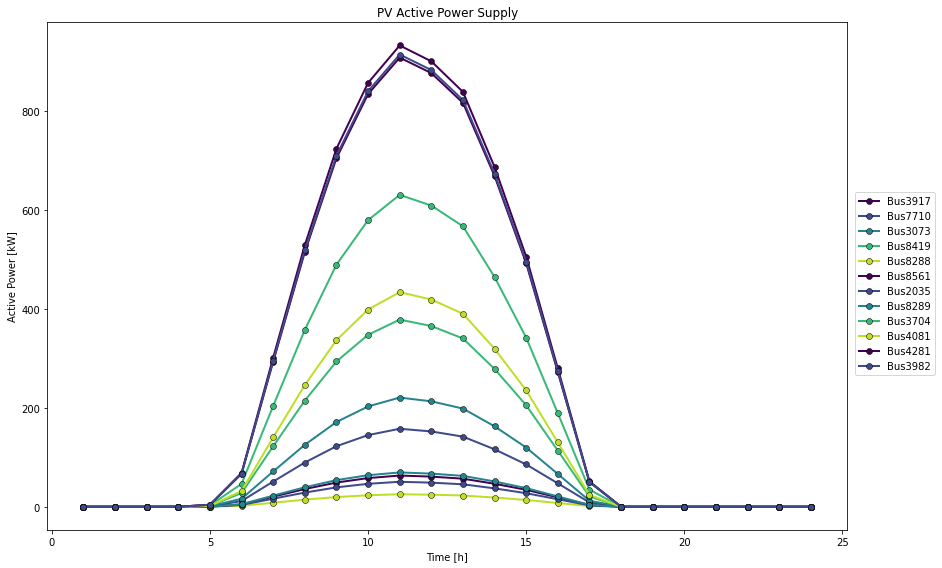

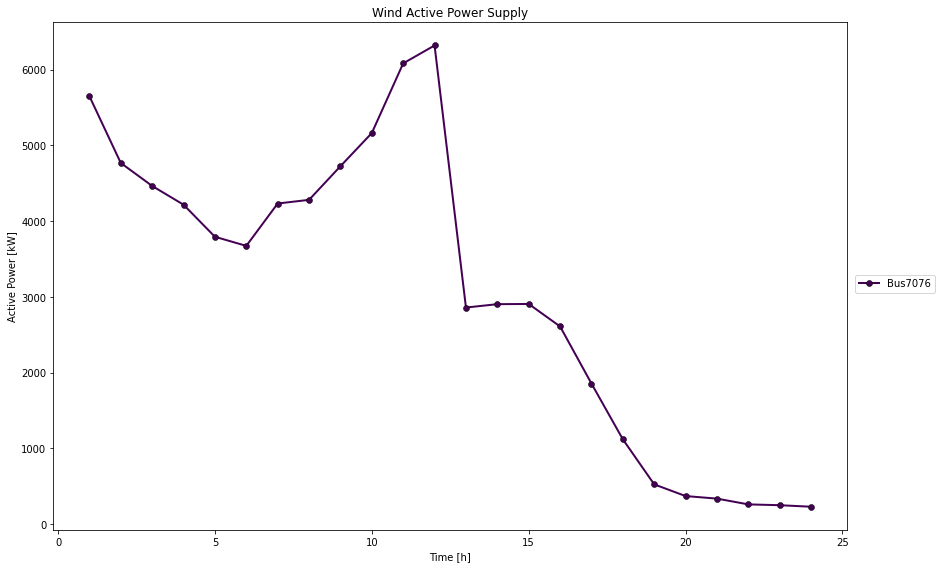

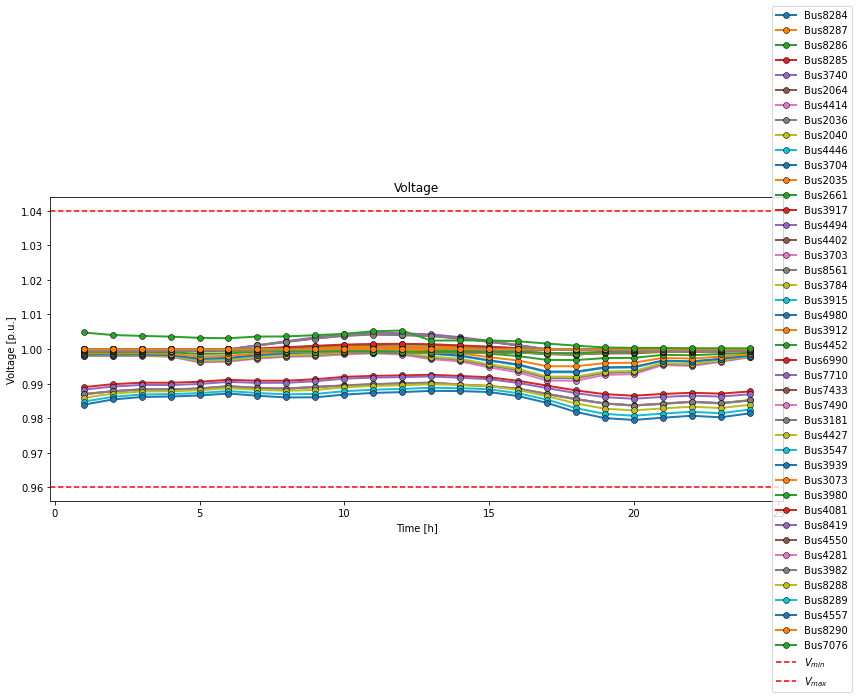

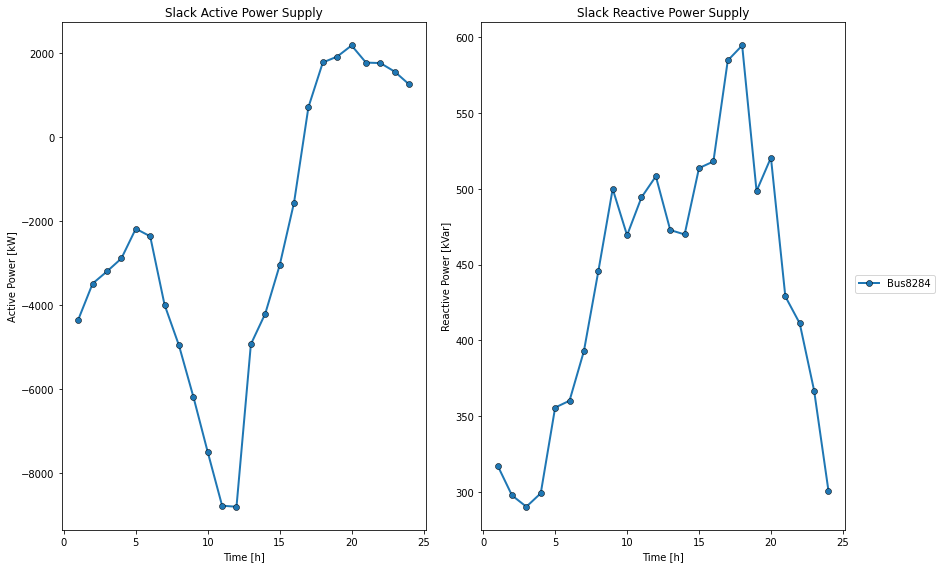

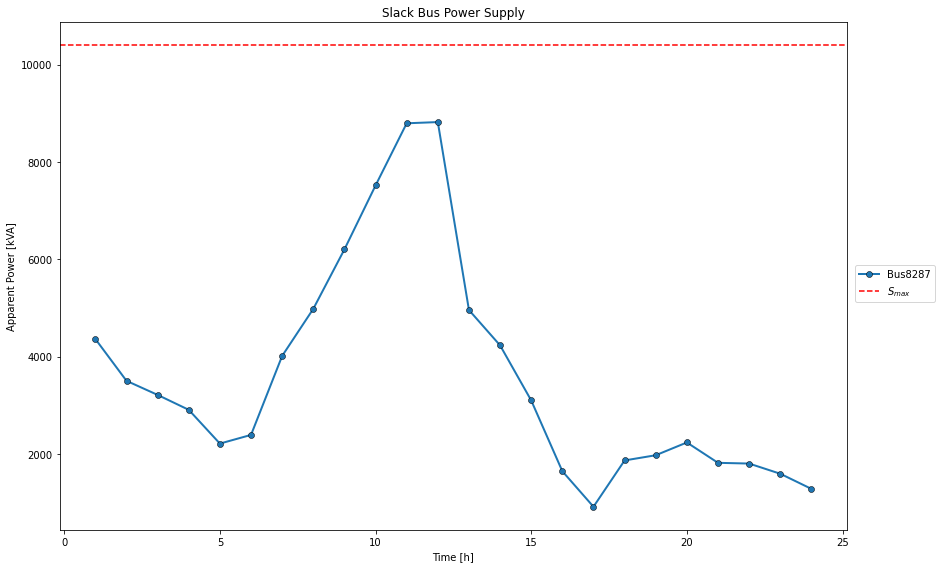

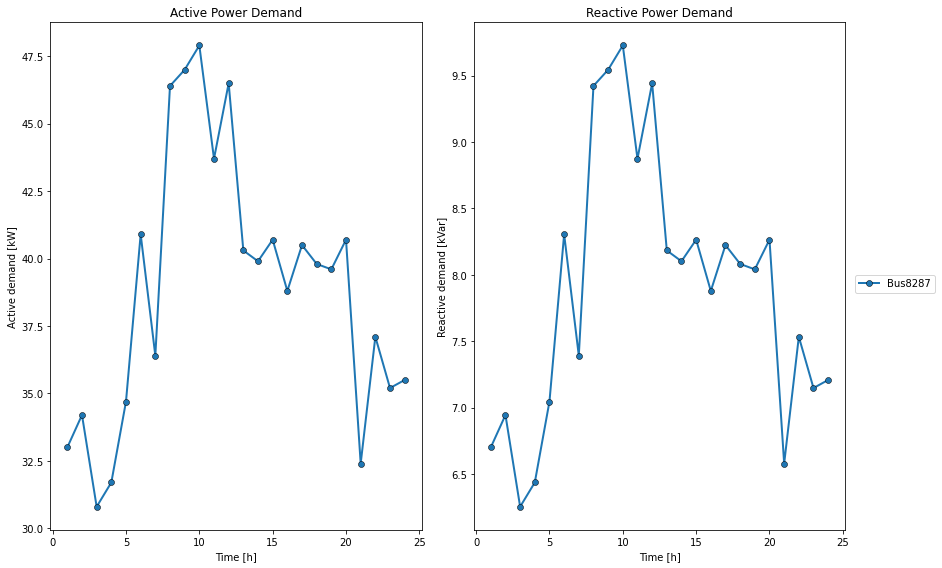

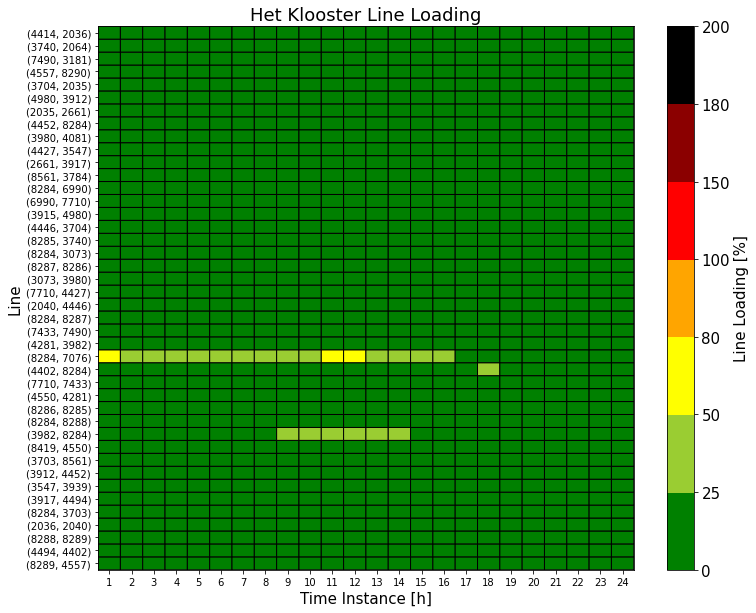

In [8]:
DSO_data_vis(base_model)

## Visualization of Monte Carlo

In [9]:
def MonteCarlo_vis(model, l, a, mrk):
    voltage = pd.DataFrame()
    active_pv = pd.DataFrame()
    active_wt = pd.DataFrame()
    active_s = pd.DataFrame()
    reactive_s = pd.DataFrame()
    apparent_s = pd.DataFrame()
    active_d = pd.DataFrame()
    reactive_d = pd.DataFrame()

    for t in model.TIME:
        for n in model.NODES:
            voltage.loc[t,n] = np.sqrt(model.V[n,t].value)
            if n == 8284:
                active_s.loc[t,n] = model.Ps[n,t].value*model.Sbase.value
                reactive_s.loc[t,n] = model.Qs[n,t].value*model.Sbase.value
                apparent_s.loc[t,n] = np.sqrt(active_s.loc[t,n]**2 + reactive_s.loc[t,n]**2)
            if n == 8287:
                active_d.loc[t,n] = model.Pd[n,t].value*model.Sbase.value
                reactive_d.loc[t,n] = model.Qd[n,t].value*model.Sbase.value
        for p in model.PV:
            active_pv.loc[t,p] = model.Ppv[p,t]*model.Sbase.value
        for w in model.WT:
            active_wt.loc[t,w] = model.Pwt[w,t]*model.Sbase.value

    Ss_max = model.Ss_max[8284].value*model.Sbase.value

    # PV active power generation
    ax_pv[0,0].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.9, 5)])
    ax_pv[0,0].plot(active_pv.index, active_pv, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5, label=[['Bus'+str(i) for i in active_pv.columns]]);ax_pv[0,0].set_xlabel('Time [h]');ax_pv[0,0].set_ylabel('Active Power [kW]');ax_pv[0,0].set_title('PV Active Power Supply')
    fig_pv.legend(['Bus'+str(i) for i in active_pv.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pv.tight_layout();
    # if l == 2:
    #     fig_pv.savefig('Visualization/MC_PV.png', bbox_inches='tight')

    # Wind active power generation
    ax_wt[0,0].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 0.9, 4)])
    ax_wt[0,0].plot(active_wt.index, active_wt, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_wt[0,0].set_xlabel('Time [h]');ax_wt[0,0].set_ylabel('Active Power [kW]');ax_wt[0,0].set_title('Wind Active Power Supply')
    fig_wt.legend(['Bus'+str(i) for i in active_wt.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_wt.tight_layout();
    # if l == 2:
    #     fig_wt.savefig('Visualization/MC_WT.png', bbox_inches='tight')

    # Voltage
    ax_v[0,0].plot(voltage.index, voltage, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage')
    if l == 2:
        ax_v[0,0].axhline(model.Vmin.value, color='r', linestyle='--', label='$V_{min}$')
        ax_v[0,0].axhline(model.Vmax.value, color='r', linestyle='--', label='$V_{max}$')
    #ax_v[0,0].legend(bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_v.tight_layout();
    # if l == 2:
    #     fig_v.savefig('Visualization/MC_V.png', bbox_inches='tight')

    # Active and reactive power demand and supply (supply only from slack bus)
    ax_pow[0,0].plot(active_s.index, active_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Active Power [kW]');ax_pow[0,0].set_title('Active Power Supply')
    ax_pow[0,1].plot(reactive_s.index, reactive_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_pow[0,1].set_xlabel('Time [h]');ax_pow[0,1].set_ylabel('Reactive Power [kVar]');ax_pow[0,1].set_title('Reactive Power Supply')
    fig_pow.legend(['Slack Bus'], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_pow.tight_layout();
    # if l == 2:
    #     fig_pow.savefig('Visualization/MC_PQ.png', bbox_inches='tight')

    # Apparent power
    ax_apow[0,0].plot(reactive_s.index, apparent_s, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_apow[0,0].set_xlabel('Time [h]');ax_apow[0,0].set_ylabel('Apparent Power [kVA]');ax_apow[0,0].set_title('Slack Bus Power Supply');
    if l == 2:
        ax_apow[0,0].axhline(Ss_max, color='r', linestyle='--', label='$S_{max}$')
    #fig_apow.legend(bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
    fig_apow.tight_layout();
    # if l == 2:
    #     fig_apow.savefig('Visualization/MC_S.png', bbox_inches='tight')

    # Active and reactive power demand from bus 15
    ax_dem[0,0].plot(active_d.index, active_d, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_dem[0,0].set_xlabel('Time [h]');ax_dem[0,0].set_ylabel('Active demand [kW]');ax_dem[0,0].set_title('Active Power Demand')
    ax_dem[0,1].plot(reactive_d.index, reactive_d, mrk, lw=l, alpha=a, markeredgecolor='k', markeredgewidth=0.5);ax_dem[0,1].set_xlabel('Time [h]');ax_dem[0,1].set_ylabel('Reactive demand [kVar]');ax_dem[0,1].set_title('Reactive Power Demand')
    fig_dem.legend(['Bus 15'], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0)
    fig_dem.tight_layout();
    # if l == 2:
    #     fig_dem.savefig('Visualization/MC_PQdem.png', bbox_inches='tight')

    # # Current profile
    # fig_i, ax_i = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
    # ax_i[0,0].plot(loading.index, loading, marker='o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5);ax_i[0,0].set_xlabel('Time [h]');ax_i[0,0].set_ylabel('Current [%]');ax_i[0,0].set_title('Current');
    # fig_i.legend(['Line '+str(i)+'-'+str(j) for i,j in loading.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
    # fig_i.tight_layout()
    # fig_i.show;
    # plt.savefig('current.png', bbox_inches='tight')

    if l == 2:
        LineData = data['LineData']
        lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
        time = list(data['SystemDemand'].loc[:,'TIME'])
        loading = pd.DataFrame(columns=lines, index=time)
        for i,j in model.LINES:
            for t in model.TIME:
                if model.I[i,j,t].value <= 0:
                    # print('WTF? Current is negative:', model.I[i,j,t].value)
                    # print('     Setting current through line:',i,j, 'at t =',t , 's to 0')
                    loading.loc[t, pd.IndexSlice[i, j]] = 0
                else:
                    loading.loc[t, pd.IndexSlice[i, j]] = np.sqrt(model.I[i,j,t].value)/(3*model.I_max[i,j].value)*100

        plt.figure(figsize=(12,10))
        cmap, norm = mcolors.from_levels_and_colors([0, 25, 50, 80, 100.01, 150, 180, 200], ['green', 'yellowgreen', 'yellow', 'orange','red', 'darkred','black'])
        plt.pcolor(loading.T, cmap=cmap, norm=norm, edgecolors='k', linewidths=1)
        plt.xticks(np.arange(0.5, len(loading.index), 1), loading.index)
        plt.yticks(np.arange(0.5, len(loading.columns), 1), loading.columns)
        plt.title("Het Klooster Line Loading",fontsize=18)
        plt.xlabel("Time Instance [h]",fontsize=15)
        cb = plt.colorbar()
        cb.set_label("Line Loading [%]",fontsize=15)
        plt.ylabel("Line",fontsize=15)
        cb.ax.tick_params(labelsize=15)
        # plt.savefig('Visualization/MC_loading_day.png', bbox_inches='tight')
        plt.show()

## Monte Carlo Simulation

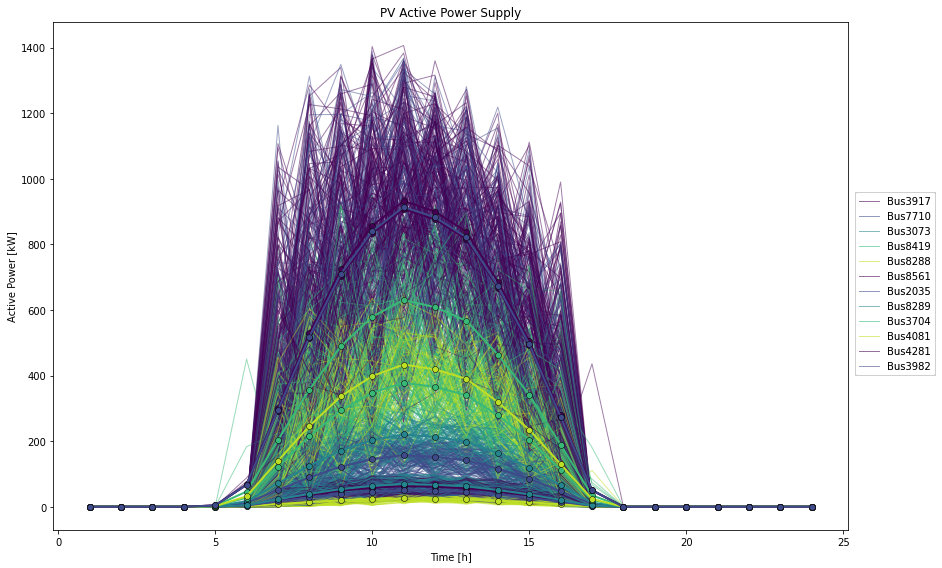

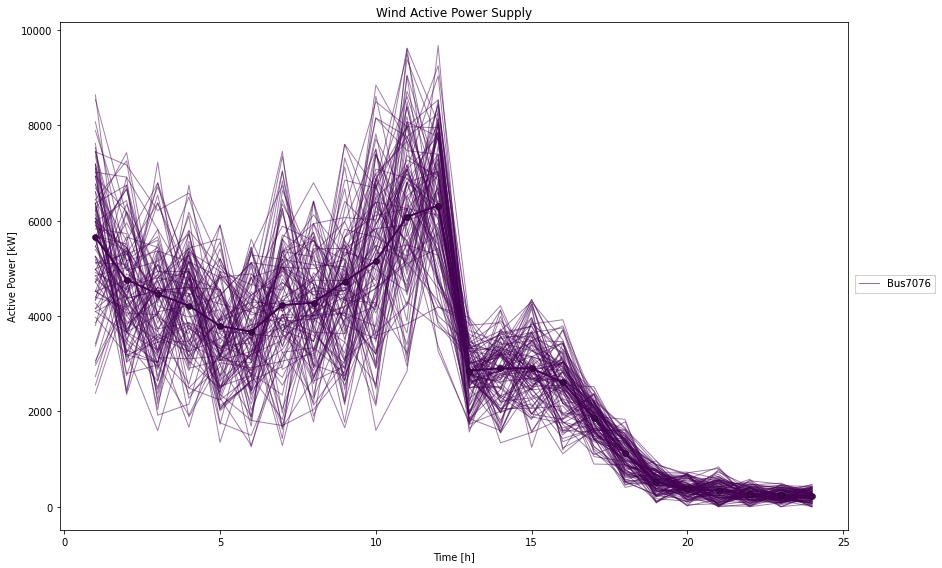

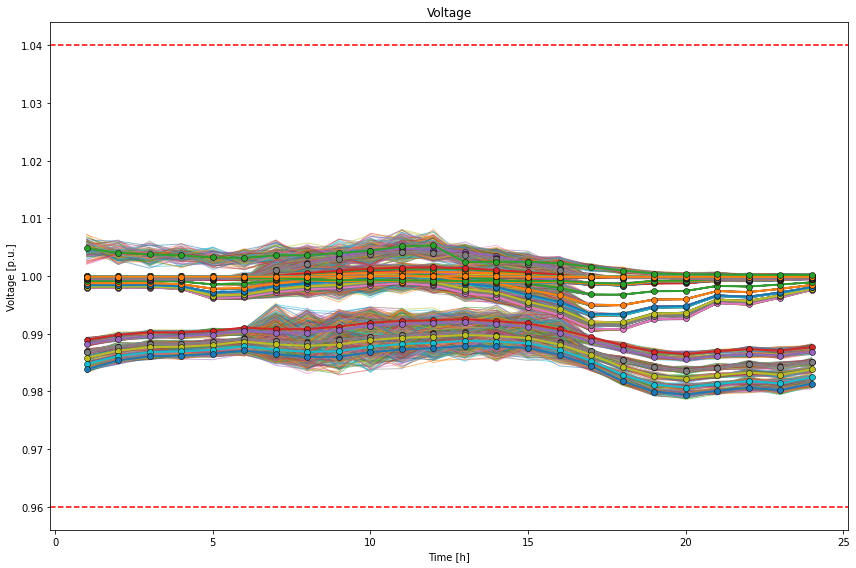

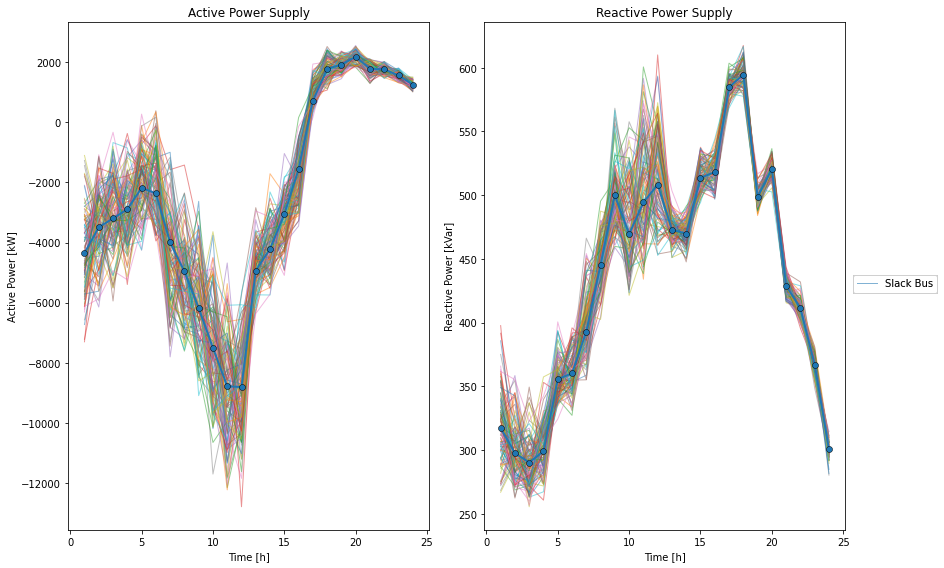

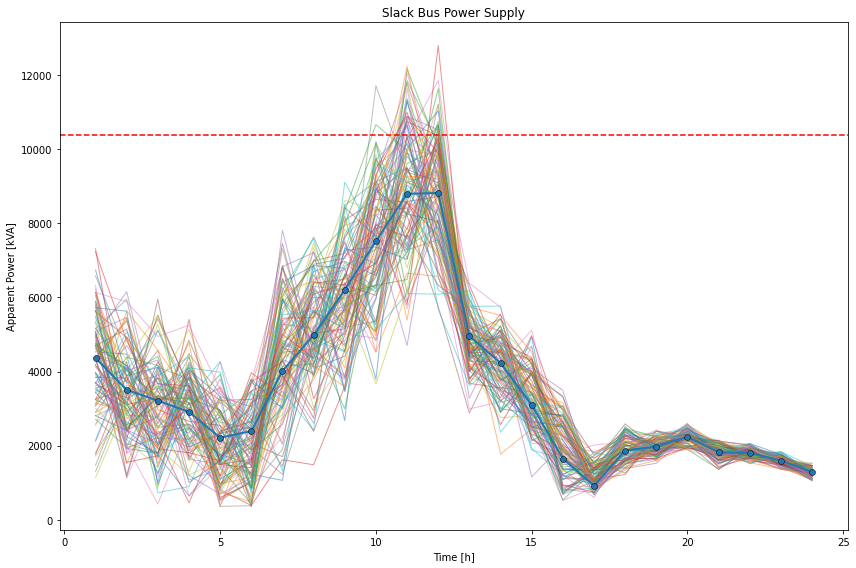

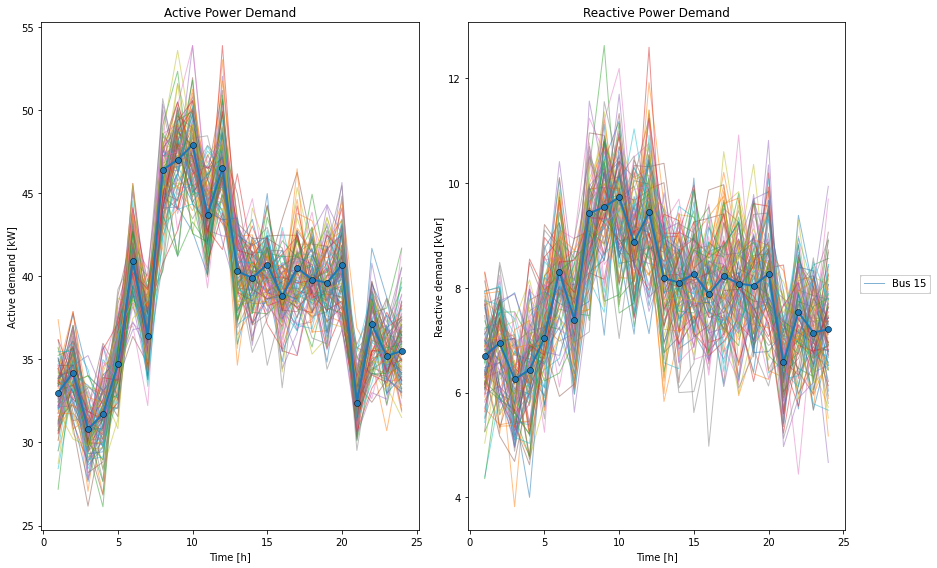

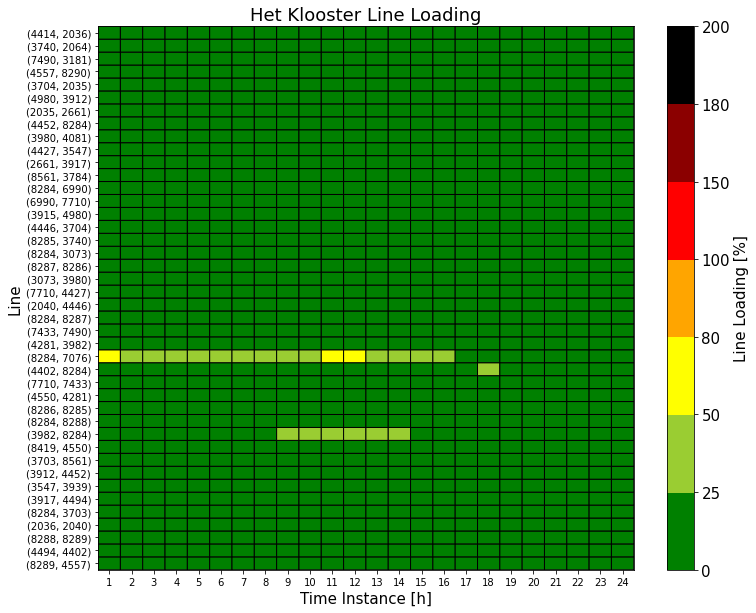

Wall time: 4min 4s


In [10]:
%%time
#initialize Monte Carlo model with fixed control variables and relaxed network constraints

case = 'MC'
fig_pv, ax_pv = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_wt, ax_wt = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_pow, ax_pow = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(12,8))
fig_apow, ax_apow = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
fig_dem, ax_dem = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(12,8))
solverMC = SolverFactory('ipopt')

for i in range(100):
    MonteCarlo_model = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, case, eta_conf, base_model)
    # solve Monte Carlo model with fixed control variables
    solverMC.solve(MonteCarlo_model)  #, tee=True)
    MonteCarlo_vis(MonteCarlo_model, l=1, a=0.5, mrk='-')
MonteCarlo_vis(base_model, l=2, a=1, mrk='-o')